In [8]:
import constants, Plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
myCmap=sns.diverging_palette(170, 330, l=65, center="dark", as_cmap=True)
physical = {constants.SHOCK: ['Time', 'Density', 'gasTemp', 'av', 'zeta', 'radfield', constants.SHOCKVEL],
            constants.HOTCORE: ['Time', 'Density', 'gasTemp', 'av', 'zeta', 'radfield']}
species=['#CH3OH', 'CH3OH', '#SIO', 'SIO']

In [12]:
tipo=constants.SHOCK

df=buildDataframe(tipo)

(            #CH3OH_log   SIO_log  CH3OH_log
 #CH3OH_log    1.000000 -0.679158        NaN
 SIO_log      -0.679158  1.000000   0.810677
 CH3OH_log          NaN  0.810677   1.000000,
 <Figure size 800x600 with 2 Axes>)

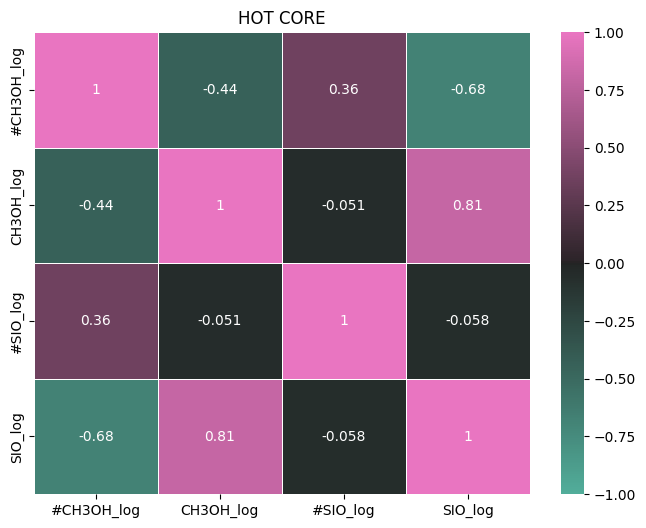

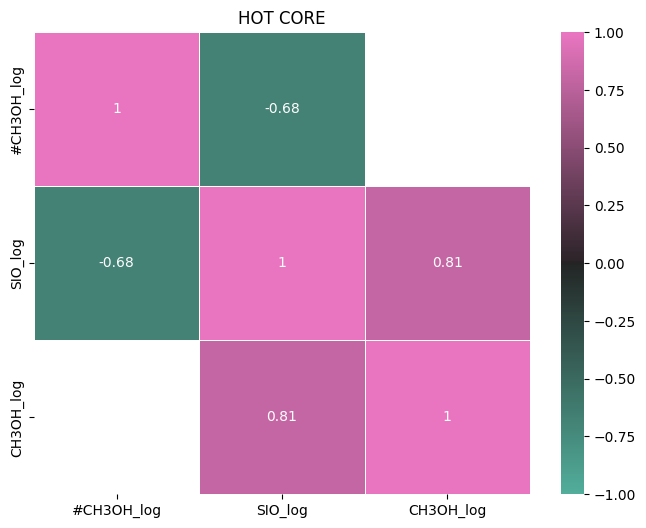

In [18]:
yaxis= [f'{prop}_log' for prop in species]
xaxis=yaxis

corr, fig = Plotting.corrGrid(df, xaxis, yaxis, tipo, 0)
xaxis, yaxis = Plotting.getCorrValues(corr)
Plotting.corrGrid(df, list(set(xaxis)), list(set(yaxis)), tipo, 0.5)

In [11]:
def buildDataframe(tipo): 
    df= pd.read_csv(tipo+'.csv', index_col=0)

    df = df.loc[:,physical[tipo]+species+['runName']]
    for prop in physical[tipo]+species:
        with np.errstate(divide='ignore'): df[f'{prop}_log']=np.log10(df[prop])
    
    df=df.reset_index().drop(columns=['index'])
    df=df.join(pd.DataFrame(df['runName'].str.replace('.dat','').str.split('_').values.tolist(),
                            columns=constants.initparams[tipo]), rsuffix='_str')
    return df

In [15]:
tipo=constants.HOTCORE

df=buildDataframe(tipo)

In [ ]:
fig = plt.figure()
axs=fig.add_subplot(111)

/data2/gsampsonolalde/uclchem_osx/lib/python3.9/site-packages/seaborn/axisgrid.py:1832: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/data2/gsampsonolalde/uclchem_osx/lib/python3.9/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/data2/gsampsonolalde/uclchem_osx/lib/python3.9/site-packages/seaborn/axisgrid.py:1889: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)
/data2/gsampsonolalde/uclchem_osx/lib/python3.9/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/data2/gsampsonolalde/uclchem_osx/lib/python3.9/site-packages/seaborn/axisgrid.py:1889: UserWarni

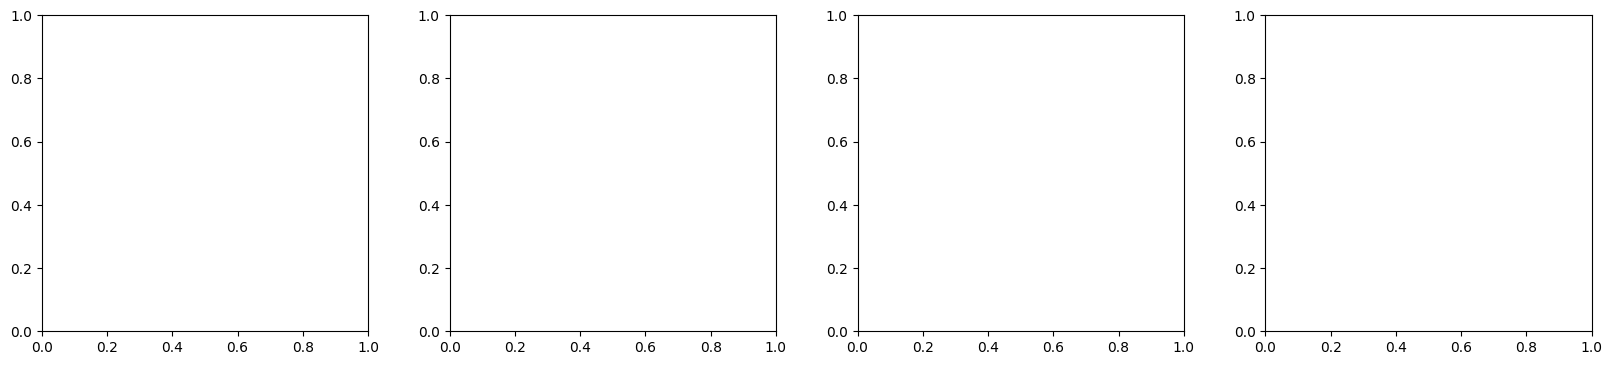

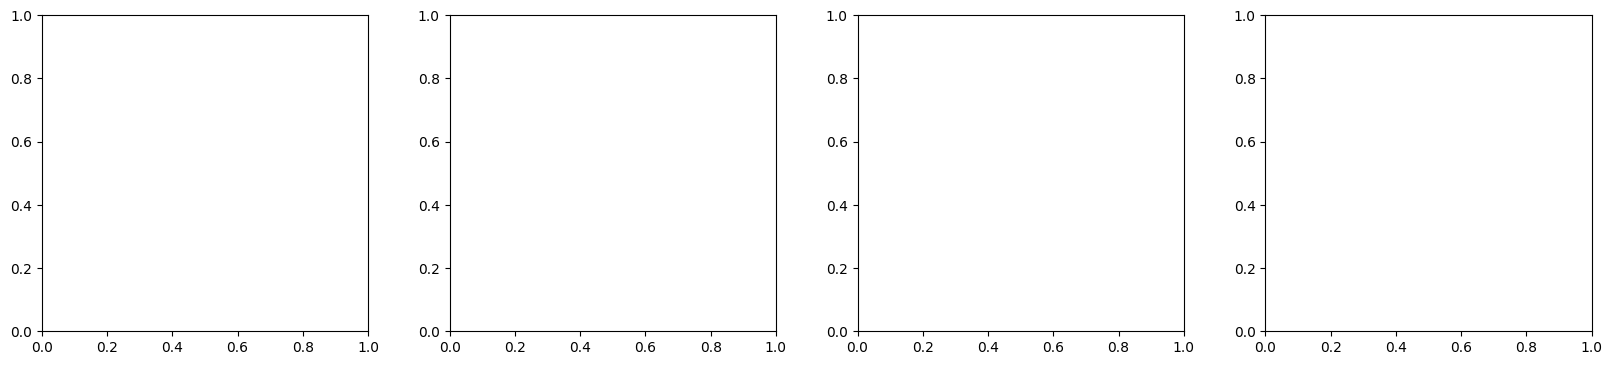

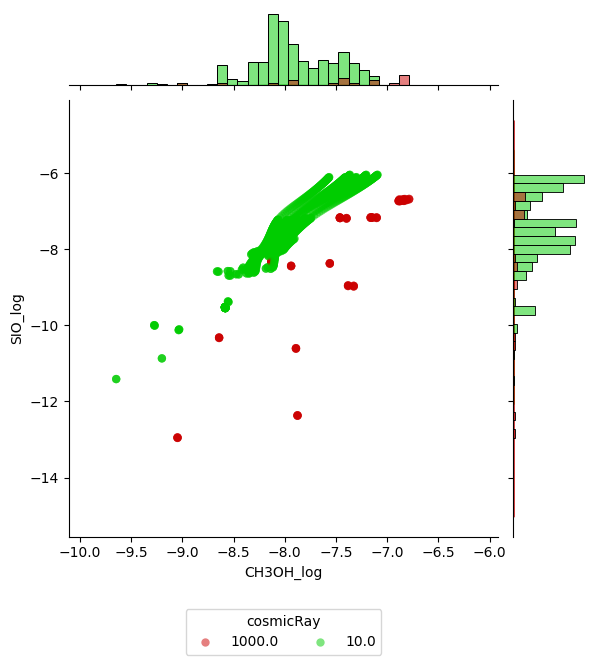

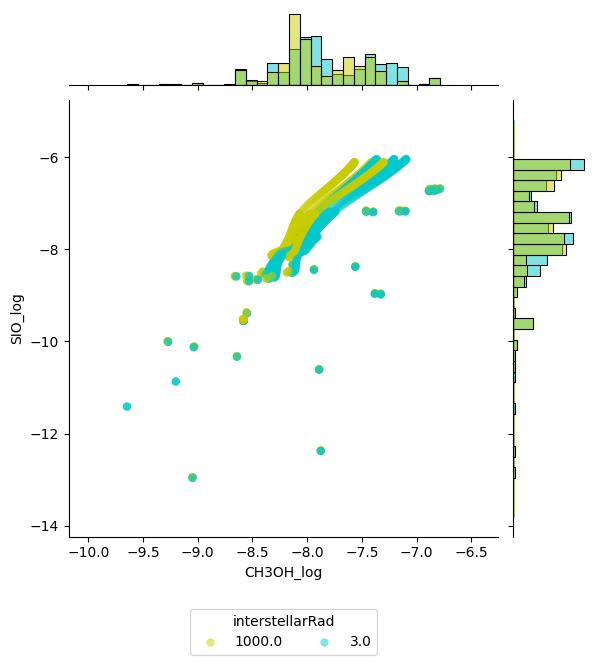

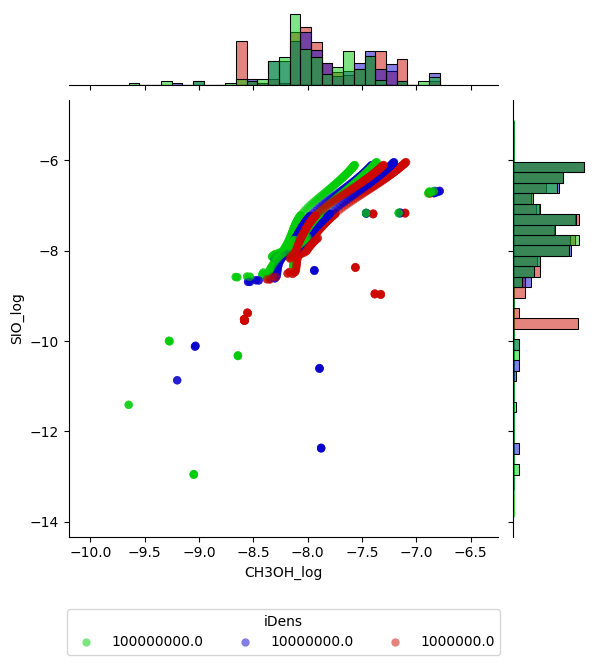

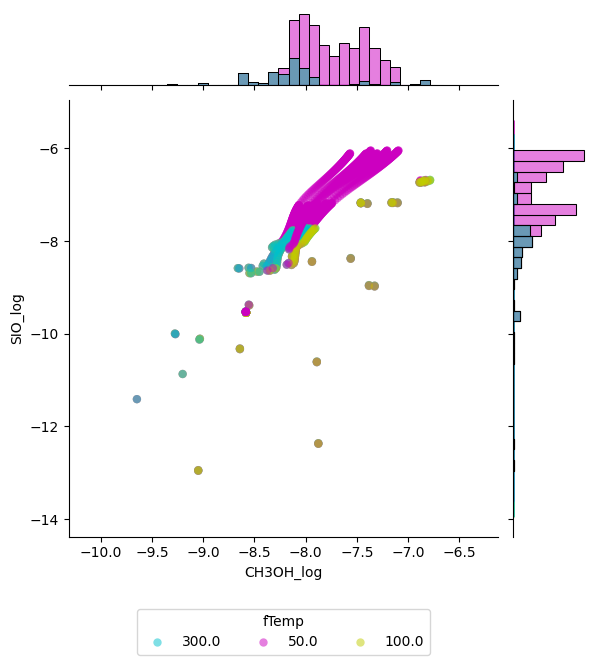

In [138]:
focusList=constants.initparams[tipo]

for j, focus in enumerate(focusList):
    f = sns.jointplot(df, y='SIO_log', x='CH3OH_log',
                    hue=focus, palette= sns.hls_palette(s=1, l=.4, h=j*.17, n_colors=3),
                    alpha=0.5, linewidth=0
                    )
    f.plot_marginals(sns.histplot, alpha=0.5)
    sns.move_legend(f.figure.axes[0], "upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
    f.savefig

# correccion corr matrix

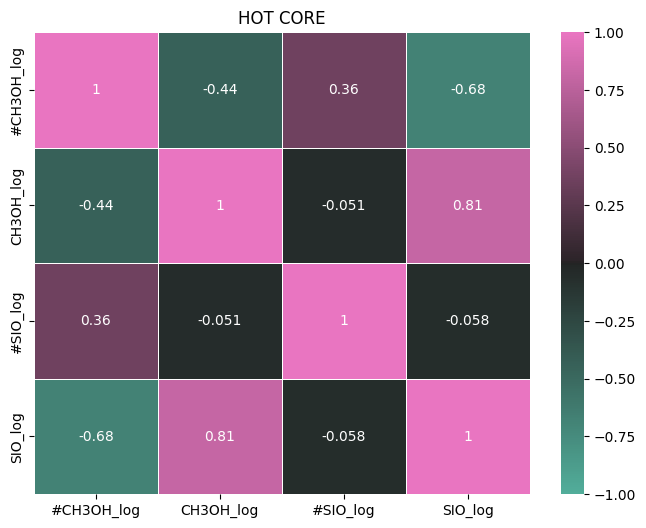

In [10]:
singleAxis=True
yaxis= [f'{prop}_log' for prop in species]
if singleAxis: xaxis=yaxis
else: xaxis= [f'{prop}_log' for prop in physical[tipo]]

figName=f"{'species_' if singleAxis else ''}CorrGrid_log_log.png"
corr, fig = Plotting.corrGrid(df, xaxis, yaxis, tipo, 0)

xaxis, yaxis = Plotting.getCorrValues(corr)

In [16]:
xaxis=list(set(xaxis))
yaxis=list(set(yaxis))

if xaxis.sort()==yaxis.sort(): singleAxis=True
else: singleAxis=False

print(singleAxis,xaxis, yaxis)

True ['#CH3OH_log', 'CH3OH_log', 'SIO_log'] ['#CH3OH_log', 'CH3OH_log', 'SIO_log']


<Axes: >

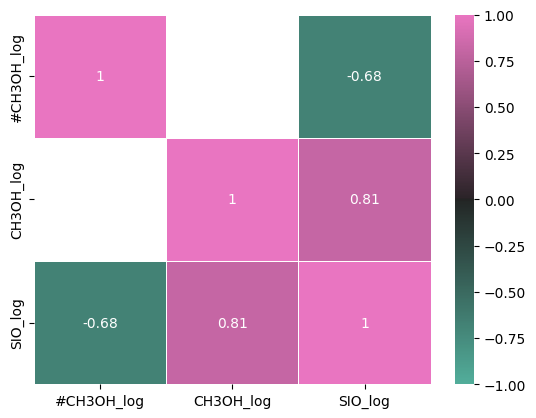

In [17]:
cor = df.loc[:,xaxis if singleAxis else xaxis+yaxis].corr()
cor=cor[cor.abs().ge(0.5)].loc[xaxis,yaxis].dropna(how='all').dropna(how='all', axis=1)
sns.heatmap(cor, vmin=-1, vmax=1, annot=True, cmap=myCmap, linewidths=.5)

In [ ]:
focusList=constants.initparams[tipo]

fig, axs = plt.subplots(1, len(focusList), figsize=(5*len(focusList),4))
fig.subplots_adjust(wspace=0.25,top=0.9)
spec='#SIO_log'
phys='gasTemp_log'

for j, focus in enumerate(focusList):
    sns.scatterplot(df,x=phys,y=spec, ax=axs[j],
                                hue= focus, palette=sns.hls_palette(s=1, l=.4, h=j*.17, n_colors=3),
                                linewidth=0, legend='full',
                                alpha=0.75, s=15
                                )
    # sns.lineplot(data=df, x=phys,y=spec, ax=axs[j],
    #                          hue= focus, palette='hls',
    #                          errorbar=lambda x: (x.min(), x.max()),
    #                          )
                
    sns.move_legend(axs[j], "upper center", bbox_to_anchor=(0.5, -0.15))

fig.suptitle(tipo.upper())

# break

In [28]:
singleAxis=False
nameBase=''
yaxis= [f'{prop}_log' for prop in species]
xaxis= [f'{prop}_log' for prop in physical[tipo]]

corr, fig = Plotting.corrGrid(df, xaxis, yaxis, tipo, 0)
xaxis, yaxis = Plotting.getCorrValues(corr, singleAxis)
plt.close()

In [33]:
def isValid(x, y):
    phases=['#','@','$']
    if x==y: return False
    elif 'Time' in x or 'Time' in y: return False
    elif x.strip('#@$')==y.strip('#@$'): return True
    for sym in phases:
        if sym in x and sym in y: return True
    return False

for i, y in enumerate(yaxis):
    if not isValid(xaxis[i], y): print(xaxis[i],y)

#CH3OH_log Time_log
CH3OH_log Time_log
SIO_log Time_log
SIO_log gasTemp_log
#SIO_log radfield_log


<Axes: xlabel='gasTemp_log', ylabel='SIO_log'>

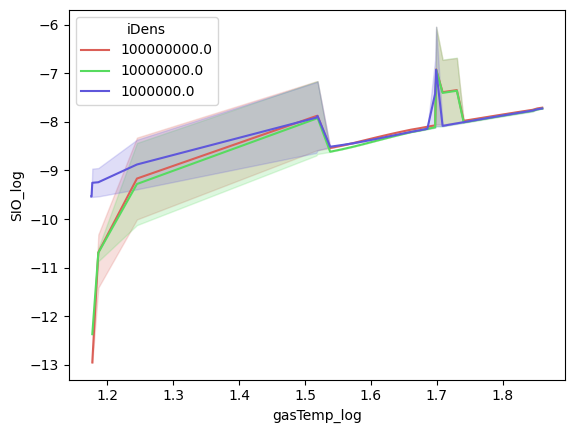

In [21]:
sns.lineplot(data=df, x="gasTemp_log", y="SIO_log", hue=constants.IDENS, palette='hls',
             errorbar=lambda x: (x.min(), x.max()))

# good scatter plot for species combination

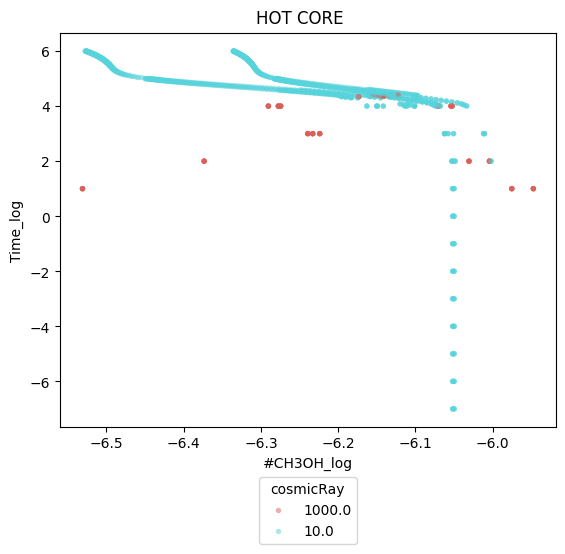

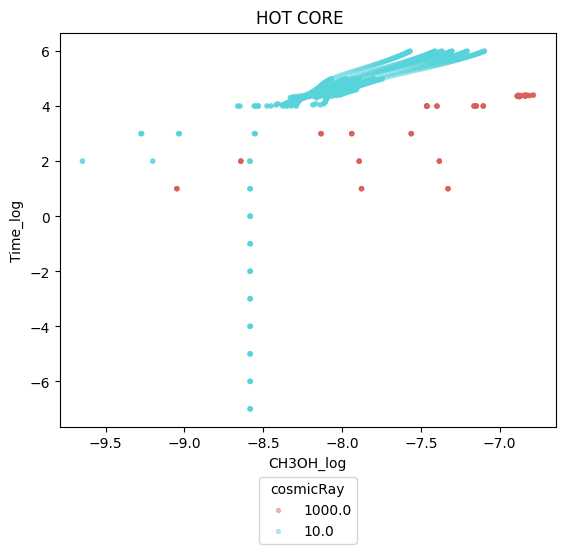

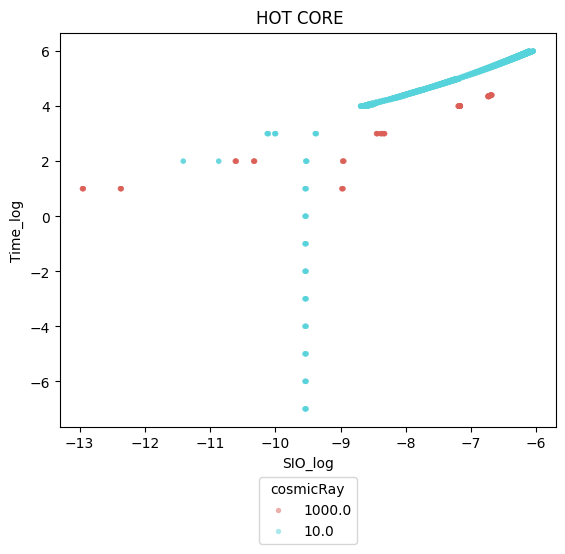

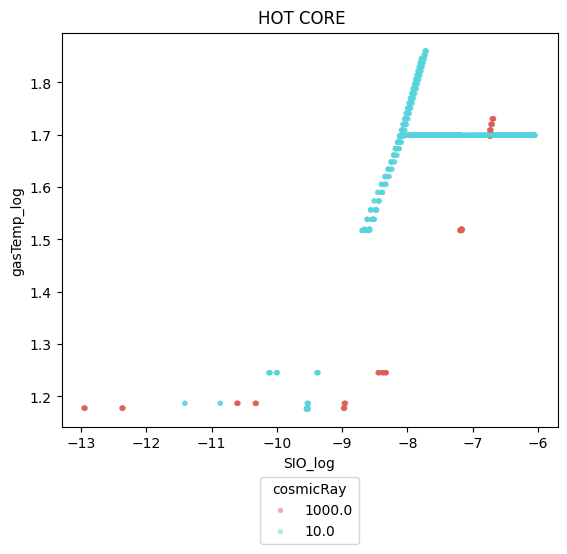

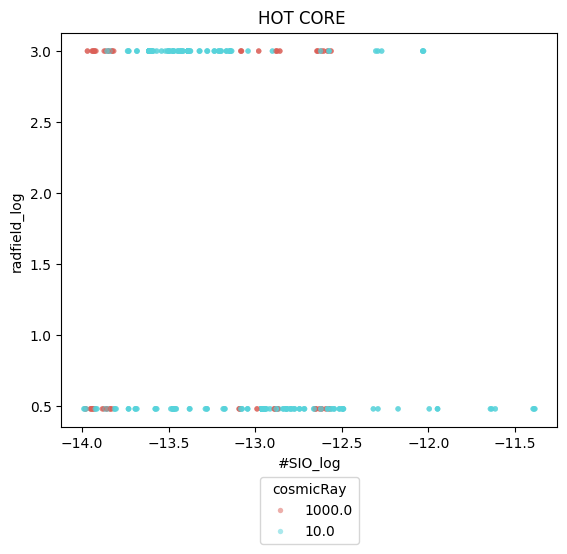

In [78]:
cosmicRay, interstellarRad, iDens, propio = constants.initparams[tipo]
for i, phys in enumerate(xaxis):
    fig = plt.figure()
    ax=fig.add_subplot(111)
    fig.subplots_adjust(top=0.93)

    spec=yaxis[i]
    figName=nameBase+phys+'_'+spec+'_'+'.png'

    ax=sns.scatterplot(df,x=phys,y=spec,
                        hue= cosmicRay,
                        palette='hls', 
                        linewidth=0, legend='full',
                        alpha=0.5, s=15
                        )
    sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, -0.11))
    fig.suptitle(tipo.upper())

# Primer intento

In [16]:
def getCorrMatrix(df, tipo, singleAxis):
    xaxis=[f'{prop}_log' for prop in species]
    yaxis= xaxis if singleAxis else [f'{prop}_log' for prop in physical[tipo]]

    cor = df.loc[:,xaxis if singleAxis else xaxis+yaxis].corr()
    cor=cor[cor.abs().ge(0.5)].loc[xaxis,yaxis].dropna(how='all').dropna(how='all', axis=1)
    return cor

In [17]:
def isValid(x, y):
    phases=['#','@','$']
    if x==y: return False
    elif x.strip('#@$')==y.strip('#@$'): return True
    for sym in phases:
        if sym in x and sym in y: return True
    return False

def getCorrValues(df, tipo, corrList, singleAxis):
    cor=getCorrMatrix(df, tipo, singleAxis)

    for i in cor.index:
        for j in cor.columns:
            if not np.isnan(cor.loc[i,j]):
                x=j.replace('_log','')
                y=i.replace('_log','')
                if singleAxis:
                    if isValid(x,y): corrList.append(pd.DataFrame(data={'tipo': tipo, 'x': x, 'y': y, 'coef': cor.loc[i,j]}, index=[0]))
                else: corrList.append(pd.DataFrame(data={'tipo': tipo, 'x': x, 'y': y, 'coef': cor.loc[i,j]}, index=[0]))

In [ ]:
corrList=[]
for tipo in physical:
    df=buildDataframe(tipo)
    for singleAxis in [False, True]:
        Plotting.getCorrValues(df, tipo, corrList, singleAxis)

corrs=pd.concat(corrList, ignore_index=True)

# pruebas

In [56]:
tipo=constants.SHOCK

df=buildDataframe(tipo)
df

In [ ]:
yaxis= [f'{prop}_log' for prop in species]
if singleAxis: xaxis=yaxis
else: xaxis= [f'{prop}_log' for prop in physical[tipo]]

corr, fig = Plotting.corrGrid(df, xaxis, yaxis, tipo, 0)
xaxis, yaxis = Plotting.getCorrValues(corr, singleAxis)

In [22]:
xaxis = [prop.replace('_log','') for prop in xaxis]
yaxis = [prop.replace('_log','') for prop in yaxis]


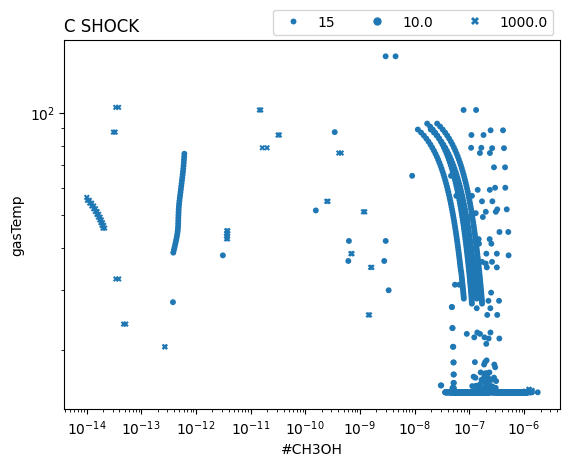

In [52]:
title=tipo
logxscale=False
logyscale=False

for i, phys in enumerate(xaxis):
    spec=yaxis[i]
    ax=sns.scatterplot(df,x=phys,y=spec,
                    # hue='zeta', palette='Spectral',
                    style='zeta',
                    linewidth=0, size=15
                    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='upper right',ncols=6, bbox_to_anchor=(1, 1.1))
    ax.set_title(title.upper(), loc='left')